# Linearity and energy resolution

I want to compute the linearity and energy resolution since I may need it for some clustering metrics.

In [13]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
import os
import yaml
import math as ma
from scipy.stats import crystalball


os.chdir('/home/bjartur/workspace/python_focalh_clustering/') # Laptop and Desktop

In [12]:
def rices_rule(arr):
    """
    Rule for choosing bin size. Cube root times 2.
    https://www.statisticshowto.com/choose-bin-sizes-statistics/#choose
    """
    return np.round((len(arr))**(1/3)*2, 0).astype(int)


# Should use crystal ball instead
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))


def lin(x,m,b):
    return m*x + b


def crystal_ball(x, alpha, n, mu, sigma, norm=True, scipy=False):
    """
    Implementation of the Crystal Ball function from: https://en.wikipedia.org/wiki/Crystal_Ball_function
     
    Backup: from scipy.stats import crystalball
    -> crystalball.pdf(x, beta=10, m=1.1, loc=0, scale=1)
    """

    if scipy:
        return crystalball.pdf(x, beta=alpha, m=n, loc=mu, scale=sigma)
    
    ret = np.zeros_like(x)

    A = (n/np.abs(alpha))**n * np.exp(-(np.abs(alpha)**2)/2)
    B = n/np.abs(alpha) - np.abs(alpha)

    if norm:
        C = (n/np.abs(alpha)) * (1/(n-1)) * np.exp(-(np.abs(alpha)**2)/2)
        D = np.sqrt(np.pi/2) * (1 + ma.erf(np.abs(alpha)/np.sqrt(2)))
        N = 1/(sigma*(C+D))
    else:
        N=1
    
    diff = x-mu
    mask = diff/sigma > -alpha

    # Case 1
    ret[mask] = N*np.exp(-0.5*(diff[mask]**2))

    # Case 2
    ret[~mask] = N * A * (B - diff[~mask])**(-n)
    
    return ret

def plot_crystal_ball(alpha, n, mu, sigma, ax, label):
    x = np.linspace(-10,10,1000)
    y = crystal_ball(x, alpha, n, mu, sigma)
    ax.plot(x,y,label=label)


In [3]:
def load_yaml(data):
    fname = "/home/bjartur/workspace/python_focalh_clustering/analysis/data.yaml"
    with open(fname, "r") as file:
        config = yaml.safe_load(file)
    return config[data]




en350 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/350_1000_uniform_noped_generic.root"
en350 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/TRAIN_E350_N5600_GEN.root"

en300 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/300_1000_uniform_noped_generic.root"
en250 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/250_1000_uniform_noped_generic.root"
en200 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/200_1000_uniform_generic.root"
en150 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/150_1000_uniform_noped_generic.root"
en100 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/100_1000_uniform_noped_generic.root"
en80 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/80_1000_uniform_noped_generic.root"
en60 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/60_1000_uniform_noped_generic.root"
en40 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/40_1000_uniform_noped_generic.root"
en20 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/20_1000_uniform_noped_generic.root"

"""
en300 = "data/train/TRAIN_E300_P1_N100.root"
en250 = "data/train/TRAIN_E250_P1_N100.root"
en200 = "data/train/TRAIN_E200_P1_N100.root"
en150 = "data/train/TRAIN_E150_P1_N100.root"
en100 = "data/train/TRAIN_E100_P1_N100.root"
en80 = "data/train/TRAIN_E80_P1_N100.root"
en60 = "data/train/TRAIN_E60_P1_N100.root"
en40 = "data/train/TRAIN_E40_P1_N100.root"
en20 = "data/train/TRAIN_E20_P1_N100.root"
"""

def adc(fname):
    tfile = ROOT.TFile(fname, "READ")
    ttree = tfile.Get("EventsTree")
    Nentries = ttree.GetEntries()
    adc = np.zeros(Nentries)
    for e in range(Nentries):
        ttree.GetEntry(e)
        vals = np.array(ttree.value, dtype=np.float32)
        adc[e] = vals.sum()
    return adc




In [4]:
adc350 = adc(en350)
adc150 = adc(en150)


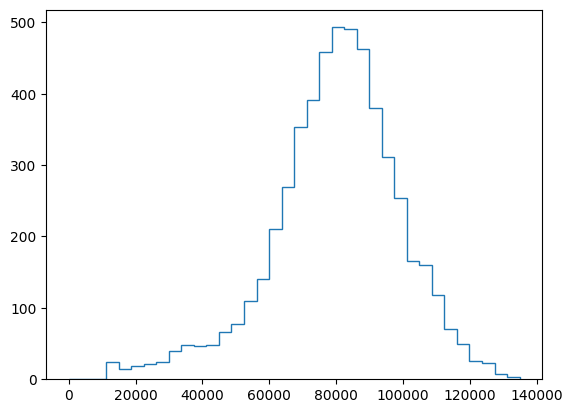

In [28]:
Nbins = rices_rule(adc350)
#Nbins = 30
hist, bins = np.histogram(adc350, bins=Nbins)
bin_centers = bins[:-1] + np.diff(bins) / 2
mask = bin_centers < 12E3
hist[mask] = 0
plt.stairs(hist, bins)


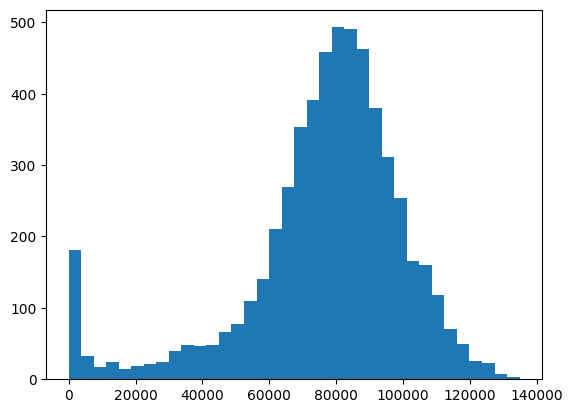

In [15]:
_ = plt.hist(adc350, bins=rices_rule(adc350))

(array([ 33.,   8.,   1.,   8.,  12.,   6.,  12.,  19.,  23.,  32.,  61.,
        102., 157., 169., 152.,  94.,  69.,  30.,  11.,   1.]),
 array([    0. ,  3354.4,  6708.8, 10063.2, 13417.6, 16772. , 20126.4,
        23480.8, 26835.2, 30189.6, 33544. , 36898.4, 40252.8, 43607.2,
        46961.6, 50316. , 53670.4, 57024.8, 60379.2, 63733.6, 67088. ]),
 <BarContainer object of 20 artists>)

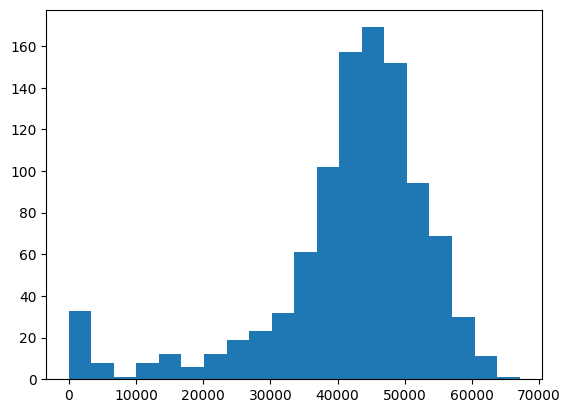

In [40]:
plt.hist(adc150, bins=rices_rule(adc150))

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.333e-10                  │              Nfcn = 134              │
│ EDM = 1.94e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha │     0     │  0.06e6   │            │            │         │         │       │
│ 1 │ n     │    0e6    │    5e6    │            │            │         │         │       │
│ 2 │ mu    │     0     │   0.4e9   │            │            │         │         │       │
│ 3 │ sigma │     0     │   0.6e9   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │     alpha         n        mu     sigma │
├───────┼─────────────────────────────────────────┤
│ alpha │  4.16e+09    -167e9      24e9 -6.606e12 │
│     n │    -167e9  2.75e+13 -0.626e15  2.603e15 │
│    mu │      24e9 -0.626e15  1.98e+17  -0.13e18 │
│ sigma │ -6.606e12  2.603e15  -0.13e18  3.96e+17 │
└───────┴─────────────────────────────────────────┘

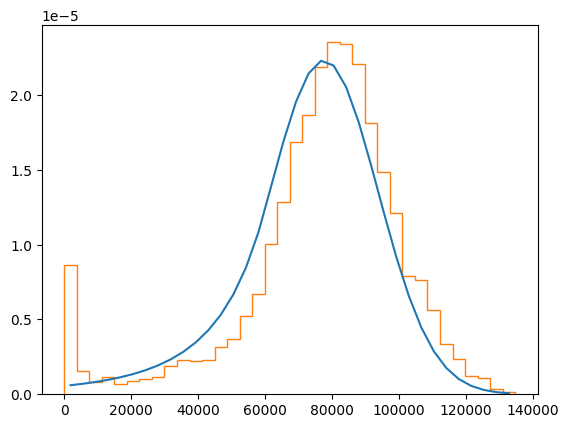

In [52]:
def fit_crystal_ball(arr):

    Nbins = rices_rule(arr)
#    Nbins = 30
    hist, bins = np.histogram(arr, bins=Nbins)
    bin_centers = bins[:-1] + np.diff(bins) / 2


    # Manual removal
#    bin_centers = bins[:-1] + np.diff(bins) / 2
#    mask = bin_centers < 12E3
#    hist[mask] = 0
    


    
#    hist = hist/hist.max()
    hist_norm = (np.sum(hist) * np.diff(bins)[0])
#    hist = hist / (hist_sum)
    hist = hist / hist_norm
    
    x_data = bin_centers
    y_data = hist

    y_data = y_data

    
    def least_squares(alpha, n, mu, sigma):
        predicted = crystal_ball(x_data, alpha, n, mu, sigma, False, True)
        return np.sum((y_data - predicted)**2)


    m = Minuit(least_squares, alpha=5, n=10, mu=arr.mean()+1E3, sigma=arr.std()/1.5)
    m.migrad()
    m.hesse()

    f_alpha = m.values['alpha']
    f_n = m.values['n']
    f_mu = m.values['mu']
    f_sigma = m.values['sigma']


    plt.plot(x_data, crystalball.pdf(x_data, beta=f_alpha, m=f_n, loc=f_mu, scale=f_sigma))
    
    plt.stairs(hist, bins)

    return m

fit_crystal_ball(adc350)

In [179]:
 5.8196e3 

5819.6

In [159]:
76.4064e3

76406.4

In [165]:
 5.8196e3 

5819.6

In [160]:
 762.4 

762.4

# Crystal Ball vs Gaussian

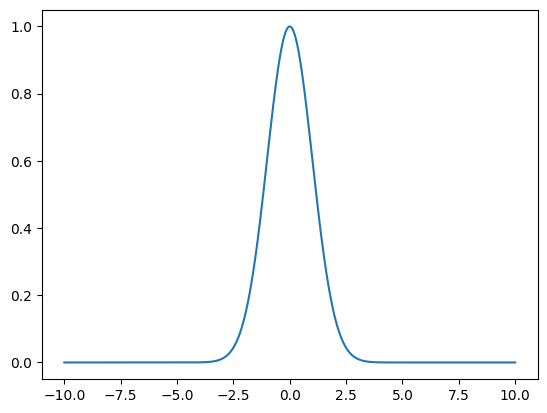

In [43]:
def plot_gaussian(A,mu,sigma):
    x = np.linspace(-10,10,1000)
    y = gaussian(x, A, mu, sigma)
    plt.plot(x,y)

plot_gaussian(1,0,1)

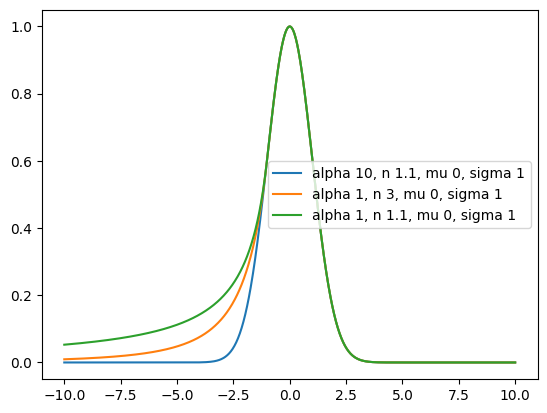

In [131]:


def plot_crystal_ball(alpha, n, mu, sigma, ax, label):
    x = np.linspace(-10,10,1000)
    y = crystal_ball(x, alpha, n, mu, sigma, False)
    ax.plot(x,y,label=label)


fig,ax = plt.subplots()
plot_crystal_ball(10, 1.1, 0, 1, ax, f"alpha {10}, n {1.1}, mu {0}, sigma {1}")
plot_crystal_ball(1, 3, 0, 1, ax, f"alpha {1}, n {3}, mu {0}, sigma {1}")
plot_crystal_ball(1, 1.1, 0, 1, ax, f"alpha {1}, n {1.1}, mu {0}, sigma {1}")

ax.legend()

#crystal_ball(np.array([1,2,3]), 1, 1, 1, 0, 1)

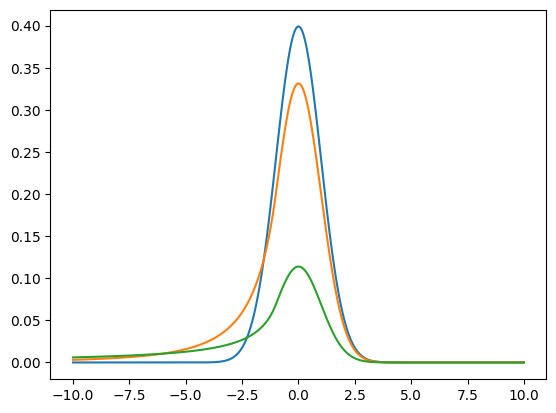

In [96]:
x = np.linspace(-10,10,1000)
y = crystalball.pdf(x, beta=10, m=1.1, loc=0, scale=1)
plt.plot(x,y)

y = crystalball.pdf(x, beta=1, m=3, loc=0, scale=1)
plt.plot(x,y)

y = crystalball.pdf(x, beta=1, m=1.1, loc=0, scale=1)
plt.plot(x,y)


#plot_crystal_ball(10, 1.1, 0, 1)
#plot_crystal_ball(1, 3, 0, 1)
#plot_crystal_ball(1, 1.1, 0, 1)


